<a href="https://colab.research.google.com/github/billumillu/Car-Detection-for-Autonomous-Driving/blob/main/Car_Detection_for_Autonomous_Driving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install q keras==2.3.1
!pip install tensorflow==1.14.0

In [3]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [2]:
import keras
print(keras.__version__)

2.3.1


In [18]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import imageio
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

In [4]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):

    # Step 1: Compute box scores
    box_scores = box_confidence * box_class_probs
    
    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1, keepdims=False)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask = box_class_scores >= threshold
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

In [5]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(
  boxes,
  scores,
  max_boxes,
  iou_threshold,
  name=None
)
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)
    
    return scores, boxes, classes

In [6]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
       
    return scores, boxes, classes

In [9]:
sess = K.get_session()

In [10]:
class_names = read_classes("./model_data/coco_classes.txt")
anchors = read_anchors("./model_data/yolo_anchors.txt")
image_shape = (720., 1280.)

In [11]:
import gdown 

url = 'https://drive.google.com/uc?export=download&id=1gzvFpm61BBicB13e0oL_SSTEY5xYz4nB'
model = 'yolo.h5'
gdown.download(url, model, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1gzvFpm61BBicB13e0oL_SSTEY5xYz4nB
To: /content/yolo.h5
204MB [00:03, 67.1MB/s]


'yolo.h5'

In [12]:
yolo_model = load_model("/content/yolo.h5")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [13]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [14]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [37]:
def predict(sess, image_file):

    # Preprocess your image
    image, image_data = preprocess_image("/content/images/" + image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    out_scores, out_boxes, out_classes = sess.run(fetches=[scores, boxes, classes],
                                                  feed_dict={yolo_model.input: image_data,
                                                             K.learning_phase():0
                                                            }
                                                 )

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("/content/out", image_file), quality=90)
    # Display the results in the notebook
    output_image = imageio.imread(os.path.join("/content/out", image_file))
    plt.figure(figsize=(15, 8))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Found 7 boxes for test.jpg
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)


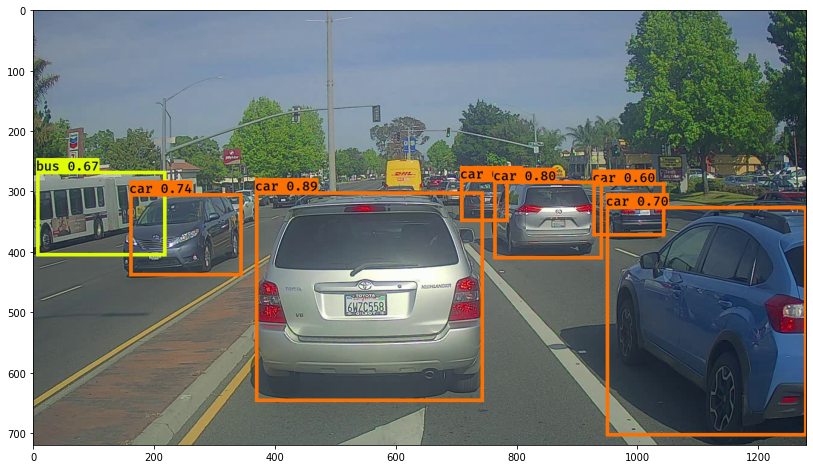

In [49]:
out_scores, out_boxes, out_classes = predict(sess, "test.jpg")